In [1]:
!nvidia-smi

Mon Jun 27 17:39:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:06:00.0 Off |                    0 |
| N/A   40C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:
import sys
sys.path.append("../") # go to parent dir

from muss_utils import get_features
from utils import *

from transformers import BartForConditionalGeneration, BartTokenizer, AutoTokenizer, AutoModel, utils
from nltk.metrics.distance import edit_distance
from string import Template
import numpy as np
import math
import random
from itertools import combinations
import torch
from pathlib import Path
import os
from typing import List, Tuple
import warnings
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
GPU = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

if torch.cuda.is_available():    
    print(torch.cuda.current_device())
    print(torch.cuda.device)
    torch.cuda.device = GPU
    print(torch.cuda.device)
    device = 'cuda'
else:
    device = 'cpu'
print(f'device: {device}')

0
<class 'torch.cuda.device'>
1
device: cuda


In [4]:
# Initialize tokenizer and model. Be sure to set output_attentions=True.
# Load BART fine-tuned for summarization on CNN/Daily Mail dataset
model_path = "/scratch/tkew/ctrl_tokens/resources/models/muss_en_mined_hf"
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path, output_attentions=True)
model = model.eval()
model = model.to(device)

In [8]:
batch_size = 24

# dataset = 'examples.en' # 
dataset = 'asset_test' # 
# dataset = 'asset_dev'
# dataset = 'turk_test'

if dataset.startswith('asset'):
    file = f'/net/cephfs/scratch/tkew/ctrl_tokens/resources/data/en/aligned/{dataset}.tsv'    
elif dataset.startswith('turk'):
    file = f'/net/cephfs/scratch/tkew/ctrl_tokens/resources/data/en/aligned/{dataset}.tsv'    
elif dataset == 'examples.en':
    file = f'/net/cephfs/scratch/tkew/ctrl_tokens/resources/data/{dataset}'    

    
outfile = Path(f'../results/access_params_and_attrs_on_{dataset}.json')
overwite = True
sample = True

In [9]:
if not outfile.exists() or overwite:
    src_sentences = read_lines(file)
    print(len(src_sentences))
    src_sentences, labels = construct_multi_label_dataset(src_sentences)
    
    if sample:
        random.seed(4)
        src_sentences = random.sample(src_sentences, 10000)
        print(len(src_sentences))

    with open(outfile, 'w', encoding='utf8') as outf:
        for batch_inputs in tqdm(batch(src_sentences, batch_size), total=len(src_sentences)/batch_size):
            batch_preds = generate(batch_inputs, model, tokenizer)    

            for src, pred in zip(batch_inputs, batch_preds):

                src_text = strip_params(src)
                pred = pred.strip()

                data = {
                    'src': src_text,
                    'pred': pred,
                    'attr': get_features(src_text, pred),
                    'params': parse_params(src),
                }

                outf.write(f'{json.dumps(data)}\n')

359


100%|██████████| 359/359 [00:18<00:00, 19.74it/s]


*** Constructed 224375 inputs ***
10000


100%|█████████▉| 416/416.6666666666667 [1:09:43<00:06, 10.03s/it]/home/cluster/tkew/.conda/envs/ctrl_tokens/lib/python3.8/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 417/416.6666666666667 [1:09:50<-1:59:57, 10.05s/it]


In [11]:
if outfile.exists():
    data = []
    with open(outfile, 'r', encoding='utf8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    df = pd.json_normalize(data)
df

,src,pred,attr.len_ratio,attr.lev_sim,attr.word_rank,attr.tree_depth,params.len_ratio,params.lev_sim,params.word_rank,params.tree_depth
0,Mifepristone is a synthetic steroid compound u...,Mifepristone is a pharmaceutical synthetic ste...,1.300000,0.732919,0.968112,1.000000,0.25,0.25,0.25,1.00
1,"The wave traveled across the Atlantic, and org...",The wave formed in a tropical depression on Se...,0.656250,0.584906,0.985499,0.714286,0.50,0.25,0.50,0.75
2,Orton and his wife welcomed Alanna Marie Orton...,"Alanna Marie Orton orton was born on July 12, ...",0.796875,0.626087,0.928506,1.000000,0.50,0.50,1.00,1.25
3,The body color varies from medium brown to gol...,The body color is medium brown to beige-white ...,0.853147,0.792453,0.919839,1.000000,0.75,0.75,0.75,0.75
4,You may add a passage of up to five words as a...,You may add a passage of up to 25 words as a B...,1.038674,0.737127,1.006839,1.181818,0.25,0.75,1.25,1.25
...,...,...,...,...,...,...,...,...,...,...
9995,Characteristics Radar observations indicate a ...,Radar observations indicate that the compositi...,0.975610,0.641975,0.935064,1.333333,0.25,0.50,0.50,0.50
9996,Addiscombe is a suburb in the London Borough o...,"Addiscombe is an area of Croydon, a suburb of ...",1.276923,0.567568,0.862647,1.333333,0.25,1.25,0.75,1.00
9997,"However, even to those who enter the prayer ha...","Even so, there are still rules that apply, for...",1.320312,0.606061,0.973329,1.285714,1.00,1.25,0.50,0.50
9998,The other incorporated cities on the Palos Ver...,Other Palos Verdes Peninsula incorporated citi...,0.953488,0.761905,0.915890,1.250000,0.75,0.75,0.25,1.00


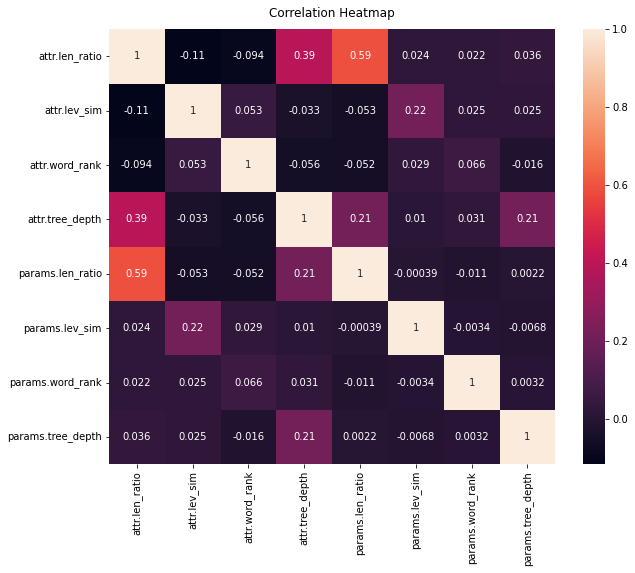

In [12]:
plt.figure(figsize=(10, 8))
# fig, axes = plt.subplots(1, 1, figsize=(16,6), sharey=True)
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

corr = df.corr()
heatmap = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

plt.savefig(f'../results/plots/surface_level_correlation_{dataset}.png', dpi=300)

In [10]:
plt.show()

In [ ]:
# print(df[['attr.len_ratio', 'params.len_ratio']].corr())
# print()
# print(df[['attr.lev_sim', 'params.lev_sim']].corr())
# print()
# print(df[['attr.word_rank', 'params.word_rank']].corr())
# print()
# print(df[['attr.tree_depth', 'params.tree_depth']].corr())


In [ ]:
# correlations = df.corr().unstack().sort_values(ascending=False)

In [ ]:
# correlations

In [ ]:
# correlations = pd.DataFrame(correlations).reset_index() # Convert to dataframe
# correlations.columns = ['col1', 'col2', 'correlation'] # Label it
# correlations

In [ ]:
# correlations.query("col1 == 'v2' & col2 != 'v2'") # Filter by variable
# # output of this code will give correlation of column v2 with all the other columns 